# Importing Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 305068946.56it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22608378.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 92582214.14it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5031835.39it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


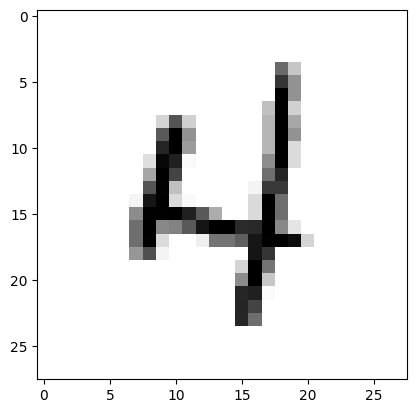

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


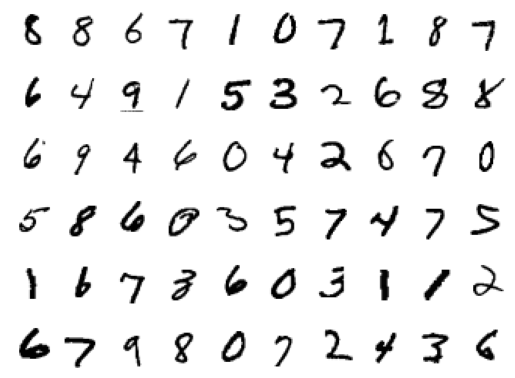

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [7]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.05720411241054535 Batch_id=468 Accuracy=88.04: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]



Test set: Average loss: 0.0617, Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.04156595095992088 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]



Test set: Average loss: 0.0441, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.033058155328035355 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0396, Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Loss=0.049378469586372375 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:19<00:00, 23.86it/s]



Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.02213093638420105 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]



Test set: Average loss: 0.0263, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.02250085212290287 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]



Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.011803981848061085 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]



Test set: Average loss: 0.0249, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.025207243859767914 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]



Test set: Average loss: 0.0281, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.017421521246433258 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]



Test set: Average loss: 0.0204, Accuracy: 9945/10000 (99.45%)

EPOCH: 9


Loss=0.15847967565059662 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.007879591546952724 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s]



Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 11


Loss=0.004495547153055668 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]



Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.02347041666507721 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]



Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.026491409167647362 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.0344221256673336 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]



Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.006191031541675329 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]



Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Loss=0.052351564168930054 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]



Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


Loss=0.040369827300310135 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.0027286987751722336 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]



Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.003214639611542225 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]



Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)



Text(0.5, 1.0, 'Test Accuracy')

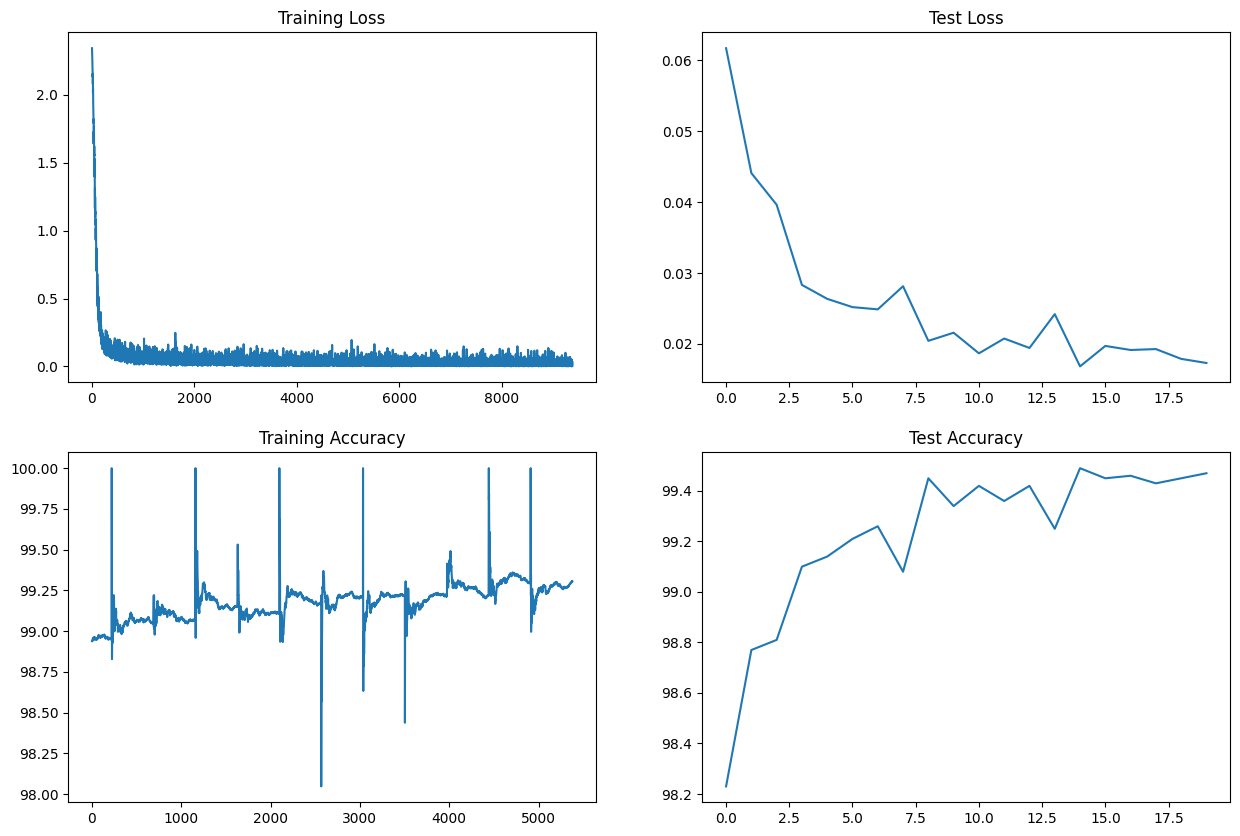

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Target
  1. Increase model capacity at the end (add layer after GAP)
  2. Perform MaxPooling at RF=5
  3. Fix DropOut, add it to each layer

# Result
  1. Parameters : 13.8k
  2. Best Train accuracy : 99.31%
  3. Best Test accuracy : 99.49%

# Analysis
  1. Here we get our desried expected accuracy of 99.4% or
  2. This time also we get some underfitting in accuracy as compared to test accuracy